# **Designer-Artifact-User multi-agent active inference demo**

In [1]:
import numpy as np
import copy

from pymdp.agent import Agent
from pymdp import utils
from pymdp.maths import softmax

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import random

import argparse
import matplotlib
## matplotlib.use("Agg") ## Use a non-GUI backend

In [2]:
## ?utils.get_model_dimensions_from_labels
## rewrite the pyMDP method to allow for shorter names so that the labels 
## dictionary can be used more easily when setting up the matrices
def get_model_dimensions_from_labels(model_labels):
    modalities = model_labels['y']
    num_modalities = len(modalities.keys())
    num_obs = [len(modalities[modality]) for modality in modalities.keys()]

    factors = model_labels['s']
    num_factors = len(factors.keys())
    num_states = [len(factors[factor]) for factor in factors.keys()]

    if 'a' in model_labels.keys():
        controls = model_labels['a']
        num_control_fac = len(controls.keys())
        num_controls = [len(controls[cfac]) for cfac in controls.keys()]
        return num_obs, num_modalities, num_states, num_factors, num_controls, num_control_fac
    else:
        return num_obs, num_modalities, num_states, num_factors

# 1 Summary of entity interactions
The following diagram is a representation of the interactions between the entities in this project. 

![](./designer-artifact-user3.png)

The Designer entity's agent has symbols:

- $a^{\mathrm{DsgArt}}$ is the action from the Designer entity's agent to the Artifact entity's environment segment
- $u^{\mathrm{ArtDsg}}$ is the inferred control states of the Artifact entity's environment segment
- $\theta^{\mathrm{ArtDsg}}$ is the inferred parameters of the Artifact entity's environment segment
- $s^{\mathrm{ArtDsg}}$ is the inferred state of the Artifact entity's environment segment
- $\theta^{\mathrm{UsrDsg}}$ is the inferred parameters of the User entity's environment segment
- $s^{\mathrm{UsrDsg}}$ is the inferred state of the User entity's environment segment

The Designer entity's environment has symbols:

- from Artifact's environment segment:
    - $y^{\mathrm{ArtDsg}}$ is the observation from the Artifact entity's environment segment
    - $\breve\theta^{\mathrm{ArtDsg}}$ is the true parameters of the Artifact entity
    - $\breve s^{\mathrm{ArtDsg}}$ is the true state of the Artifact entity
    - $W^{\mathrm{Art}}$ is the exogenous information impacting the Artifact entity
- from User's environment segment:
    - $y^{\mathrm{UsrDsg}}$ is the observation from the User entity's environment segment
    - $\breve\theta^{\mathrm{UsrDsg}}$ is the true parameters of the User entity
    - $\breve s^{\mathrm{UsrDsg}}$ is the true state of the User entity

The Artifact entity's agent has symbols:

- $a^{\mathrm{ArtUsr}}$ is the action from the Artifact entity's agent to the User entity's environment segment
- $u^{\mathrm{UsrArt}}$ is the inferred control states of the User entity's environment segment
- $\theta^{\mathrm{UsrArt}}$ is the inferred parameters of the User entity's environment segment
- $s^{\mathrm{UsrArt}}$ is the inferred state of the User entity's environment segment

The Artifact entity's environment has symbols:

- from User's environment segment:
    - $y^{\mathrm{UsrArt}}$ is the observation from the User entity's environment segment
    - $\breve\theta^{\mathrm{UsrArt}}$ is the true parameters of the User entity
    - $\breve s^{\mathrm{UsrArt}}$ is the true state of the User entity
    - $W^{\mathrm{Usr}}$ is the exogenous information impacting the User entity

The User entity's agent has symbols:

- $a^{\mathrm{UsrArt}}$ is the action from the User entity's agent to the Artifact entity's environment segment
- $u^{\mathrm{ArtUsr}}$ is the inferred control states of the Artifact entity's environment segment
- $\theta^{\mathrm{ArtUsr}}$ is the inferred parameters of the Artifact entity's environment segment
- $s^{\mathrm{ArtUsr}}$ is the inferred state of the User entity's environment segment

The User entity's environment has symbols:

- from Artifact's environment segment:
    - $y^{\mathrm{ArtUsr}}$ is the observation from the Artifact entity's environment segment
    - $\breve\theta^{\mathrm{ArtUsr}}$ is the true parameters of the Artifact entity
    - $\breve s^{\mathrm{ArtUsr}}$ is the true state of the Artifact entity
    - $W^{\mathrm{Art}}$ is the exogenous information impacting the Artifact entity

# 2 Entity interactions

## 2.1 Designer agent
This is the Designer agent's *generative model* for its environment.

### 2.1.1 State factors
The inferred state factors from the Designer's environment are:

- $s^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING)
- $s^{\mathrm{ArtDsg}}_2$ (TIME_ON_TASK)
- $s^{\mathrm{ArtDsg}}_3$ (UI_FEATURES) [LATER]
- $s^{\mathrm{ArtDsg}}_4$ (PERFORMANCE) [LATER]
- $s^{\mathrm{UsrDsg}}_1$ (FEEDBACK) [LATER]

#### 2.1.1.1 $s^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING)
It has two possible values:

- $s^{\mathrm{ArtDsg}}_1 = 0$, `FOCUSED`
- $s^{\mathrm{ArtDsg}}_1 = 1$, `SCATTERED`

#### 2.1.1.2 $s^{\mathrm{Art}}_2$ (TIME_ON_TASK)
It has three possible values:

- $s^{\mathrm{ArtDsg}}_2 = 0$, `SHORT`
- $s^{\mathrm{ArtDsg}}_2 = 1$, `MEDIUM`
- $s^{\mathrm{ArtDsg}}_2 = 2$, `LONG`

#### 2.1.1.3 $s^{\mathrm{ArtDsg}}_3$ (UI_FEATURES) [LATER]
It has three possible values: 

- $s^{\mathrm{ArtDsg}}_3 = 0$, `MINIMAL`
- $s^{\mathrm{ArtDsg}}_3 = 1$, `STANDARD`
- $s^{\mathrm{ArtDsg}}_3 = 2$, `ADVANCED`

#### 2.1.1.4 $s^{\mathrm{ArtDsg}}_4$ (PERFORMANCE) [LATER]
It has three possible values:

- $s^{\mathrm{ArtDsg}}_4 = 0$, `LOW`
- $s^{\mathrm{ArtDsg}}_4 = 1$, `MEDIUM`
- $s^{\mathrm{ArtDsg}}_4 = 2$, `HIGH`

#### 2.1.1.5 $s^{\mathrm{UsrDsg}}_1$ (FEEDBACK) [LATER]
It has two possible values:

- $s^{\mathrm{UsrDsg}}_1 = 0$, `POSITIVE`
- $s^{\mathrm{UsrDsg}}_1 = 1$, `NEGATIVE`

### 2.1.2 Observation modalities 
The observed observation modalities from the Designer's environment (inputs to the Designer agent) are:

- $y^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING_OBS)
- $y^{\mathrm{ArtDsg}}_2$ (TIME_ON_TASK_OBS)
- $y^{\mathrm{ArtDsg}}_3$ (UI_FEATURES_OBS)
- $y^{\mathrm{ArtDsg}}_4$ (PERFORMANCE_OBS) [LATER]
- $y^{\mathrm{UsrDsg}}_1$ (FEEDBACK_OBS) [LATER]

#### 2.1.2.1 $y^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING_OBS)
It has three possible values:

- $y^{\mathrm{ArtDsg}}_1 = 0$, `FOCUSED_OBS`
- $y^{\mathrm{ArtDsg}}_1 = 1$, `SCATTERED_OBS`
- $y^{\mathrm{ArtDsg}}_1 = 2$, `NEUTRAL_OBS`

#### 2.1.2.2 $y^{\mathrm{ArtDsg}}_2$ (TIME_ON_TASK_OBS)
It has three possible values:

- $y^{\mathrm{ArtDsg}}_2 = 0$, `SHORT_OBS`
- $y^{\mathrm{ArtDsg}}_2 = 1$, `MEDIUM_OBS`
- $y^{\mathrm{ArtDsg}}_2 = 2$, `LONG_OBS`

#### 2.1.2.3 $y^{\mathrm{ArtDsg}}_3$ (UI_FEATURES_OBS)
It has three possible values: 

- $y^{\mathrm{ArtDsg}}_3 = 0$, `MINIMAL_OBS`
- $y^{\mathrm{ArtDsg}}_3 = 1$, `STANDARD_OBS`
- $y^{\mathrm{ArtDsg}}_3 = 2$, `ADVANCED_OBS`

#### 2.1.2.4 $y^{\mathrm{ArtDsg}}_4$ (PERFORMANCE_OBS) [LATER]
It has three possible values:

- $y^{\mathrm{ArtDsg}}_4 = 0$, `LOW_OBS`
- $y^{\mathrm{ArtDsg}}_4 = 1$, `MEDIUM_OBS`
- $y^{\mathrm{ArtDsg}}_4 = 2$, `HIGH_OBS`

#### 2.1.2.5 $y^{\mathrm{UsrDsg}}_1$ (FEEDBACK_OBS) [LATER]
It has two possible values:

- $y^{\mathrm{UsrDsg}}_1 = 0$, `POSITIVE_OBS`
- $y^{\mathrm{UsrDsg}}_1 = 1$, `NEGATIVE_OBS`

### 2.1.3 Control factors
The action control factors to the Designer's environment (outputs from the Designer agent) are:

- $a^{\mathrm{DsgArt}}_1$ (NULL)
- $a^{\mathrm{DsgArt}}_2$ (ADJUST_UI_FEATURES_ACTION)

#### 2.1.3.1 $a^{\mathrm{DsgArt}}_1$ (NULL)
It has one possible value:

- $a^{\mathrm{DsgArt}}_1 = 0$, `NULL_ACT`

#### 2.1.3.2 $a^{\mathrm{DsgArt}}_2$ (ADJUST_UI_FEATURES_ACTION)
It has three possible values:

- $a^{\mathrm{DsgArt}}_1 = 0$, `NO_CHANGE_ACT`
- $a^{\mathrm{DsgArt}}_2 = 1$, `CHANGE_COLOR_THEME_ACT`
- $a^{\mathrm{DsgArt}}_3 = 2$, `CHANGE_TEXT_SIZE_ACT`

In [3]:
_labDsg = { ## labels for Designer
    "a": {
        "aᴰˢᵍᴬʳᵗ₁": [ ## "NULL"
            "NULL_ACT", 
        ],
        "aᴰˢᵍᴬʳᵗ₂": [ ## "ADJUST_UI_FEATURES_ACTION"
            "NO_CHANGE_ACT", 
            "CHANGE_COLOR_THEME_ACT", 
            "CHANGE_TEXT_SIZE_ACT"
        ],
    },
    "s": {
        "sᴬʳᵗᴰˢᵍ₁": [ ## "EYE_TRACKING"
            "FOCUSED", 
            "SCATTERED",
        ],
        "sᴬʳᵗᴰˢᵍ₂": [ ## "TIME_ON_TASK"
            "SHORT", 
            "MEDIUM", 
            "LONG"
        ],
        ## LATER:
        # "sᴬʳᵗᴰˢᵍ₃": [ ## "UI_FEATURES"
        #     "MINIMAL", 
        #     "STANDARD", 
        #     "ADVANCED"
        # ],
        # "sᴬʳᵗᴰˢᵍ₄": [ ## "PERFORMANCE"
        #     "LOW", 
        #     "MEDIUM", 
        #     "HIGH"
        # ],
        # "sᵁˢʳᴰˢᵍ₁": [ ## "FEEDBACK"
        #     "POSITIVE", 
        #     "NEGATIVE"
        # ],
    },
    "s̆": {
        "s̆ᴬʳᵗᴰˢᵍ₁": [ ## "EYE_TRACKING"
            "FOCUSED", 
            "SCATTERED",
        ],
        "s̆ᴬʳᵗᴰˢᵍ₂": [ ## "TIME_ON_TASK"
            "SHORT", 
            "MEDIUM", 
            "LONG"
        ],
    },    
    "y": {
        "yᴬʳᵗᴰˢᵍ₁": [ ## "EYE_TRACKING_OBS"
            "FOCUSED_OBS",
            "SCATTERED_OBS",
            "NEUTRAL_OBS"
        ],
        "yᴬʳᵗᴰˢᵍ₂": [ ## "TIME_ON_TASK_OBS"
            "SHORT_OBS",
            "MEDIUM_OBS",
            "LONG_OBS"
        ],
        "yᴬʳᵗᴰˢᵍ₃": [ ## "UI_FEATURES_OBS"
            "MINIMAL_OBS",
            "STANDARD_OBS",
            "ADVANCED_OBS"
        ],
        ## LATER:
        # "yᴬʳᵗᴰˢᵍ₄": [ ## "PERFORMANCE_OBS"
        #     "LOW_OBS",
        #     "MEDIUM_OBS",
        #     "HIGH_OBS"
        # ],
        # "yᵁˢʳᴰˢᵍ₁": [ ## "FEEDBACK_OBS"
        #     "POSITIVE_OBS",
        #     "NEGATIVE_OBS"
        # ]
    },
}
_yArtDsg_car,_yArtDsg_num, _sArtDsg_car,_sArtDsg_num, _aDsgArt_car,_aDsgArt_num = get_model_dimensions_from_labels(_labDsg)
_yArtDsg_car,_yArtDsg_num, _sArtDsg_car,_sArtDsg_num, _aDsgArt_car,_aDsgArt_num

([3, 3, 3], 3, [2, 3], 2, [1, 3], 2)

In [4]:
print(f'{_aDsgArt_car=}') ## cardinality of control factors
print(f'{_aDsgArt_num=}') ## number of control factors

print(f'{_sArtDsg_car=}') ## cardinality of state factors
print(f'{_sArtDsg_num=}') ## number of state factors

print(f'{_yArtDsg_car=}') ## cardinality of observation modalities
print(f'{_yArtDsg_num=}') ## number of observation modalities

_aDsgArt_car=[1, 3]
_aDsgArt_num=2
_sArtDsg_car=[2, 3]
_sArtDsg_num=2
_yArtDsg_car=[3, 3, 3]
_yArtDsg_num=3


In [5]:
_aDsgArt_fac_names = list(_labDsg['a'].keys()); print(f'{_aDsgArt_fac_names=}') ## control factor names
_sArtDsg_fac_names = list(_labDsg['s'].keys()); print(f'{_sArtDsg_fac_names=}') ## state factor names
_s̆ArtDsg_fac_names = list(_labDsg['s̆'].keys()); print(f'{_s̆ArtDsg_fac_names=}') ## state factor names
_yArtDsg_mod_names = list(_labDsg['y'].keys()); print(f'{_yArtDsg_mod_names=}') ## observation modality names

_aDsgArt_fac_names=['aᴰˢᵍᴬʳᵗ₁', 'aᴰˢᵍᴬʳᵗ₂']
_sArtDsg_fac_names=['sᴬʳᵗᴰˢᵍ₁', 'sᴬʳᵗᴰˢᵍ₂']
_s̆ArtDsg_fac_names=['s̆ᴬʳᵗᴰˢᵍ₁', 's̆ᴬʳᵗᴰˢᵍ₂']
_yArtDsg_mod_names=['yᴬʳᵗᴰˢᵍ₁', 'yᴬʳᵗᴰˢᵍ₂', 'yᴬʳᵗᴰˢᵍ₃']


### 2.1.4 Observation likelihood matrix, $\mathbf A$
We now setup the observation likelihood matrix which is the first main component of generative model.

In [6]:
_Aᴬʳᵗᴰˢᵍ = utils.obj_array_zeros([[y_car] + _sArtDsg_car for y_car in _yArtDsg_car])
print(f'{len(_Aᴬʳᵗᴰˢᵍ)=}')
_Aᴬʳᵗᴰˢᵍ

len(_Aᴬʳᵗᴰˢᵍ)=3


array([array([[[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]]]), array([[[0., 0., 0.],
                                        [0., 0., 0.]],

                                       [[0., 0., 0.],
                                        [0., 0., 0.]],

                                       [[0., 0., 0.],
                                        [0., 0., 0.]]]),
       array([[[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]]])], dtype=object)

#### 2.1.4.1 Observation modality $y^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{ArtDsg}}_1$ (EYE_TRACKING_OBS) is related to hidden states.

In [7]:
_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('NEUTRAL_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('SHORT')
] = 1.0
_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('NEUTRAL_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = 1.0
_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('FOCUSED_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 0.8
_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('SCATTERED_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 0.2

_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('SCATTERED_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 0.8
_Aᴬʳᵗᴰˢᵍ[0][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('FOCUSED_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 0.2

_Aᴬʳᵗᴰˢᵍ[0]

array([[[0. , 0. , 0.8],
        [0. , 0. , 0.2]],

       [[0. , 0. , 0.2],
        [0. , 0. , 0.8]],

       [[1. , 1. , 0. ],
        [1. , 1. , 0. ]]])

#### 2.1.4.2 Observation modality $y^{\mathrm{ArtDsg}}_2$ (TIME_ON_TASK_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{ArtDsg}}_2$ (TIME_ON_TASK_OBS) is related to hidden states.

In [8]:
_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('LONG_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('SHORT')
] = 1.0

_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('LONG_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 1.0

_FOCUSED_MAPPING_DSG = softmax(np.array([1.0, 0]))
_SCATTERED_MAPPING_DSG = softmax(np.array([0.0, 1.0]))

_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('SHORT_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = _FOCUSED_MAPPING_DSG[0]
_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('MEDIUM_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = _FOCUSED_MAPPING_DSG[1]

_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('SHORT_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = _SCATTERED_MAPPING_DSG[0]
_Aᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('MEDIUM_OBS'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = _SCATTERED_MAPPING_DSG[1]

_Aᴬʳᵗᴰˢᵍ[1]

array([[[0.        , 0.73105858, 0.        ],
        [0.        , 0.26894142, 0.        ]],

       [[0.        , 0.26894142, 0.        ],
        [0.        , 0.73105858, 0.        ]],

       [[1.        , 0.        , 1.        ],
        [1.        , 0.        , 1.        ]]])

#### 2.1.4.3 Observation modality $y^{\mathrm{ArtDsg}}_3$ (UI_FEATURES_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{ArtDsg}}_3$ (UI_FEATURES_OBS) is related to hidden states.

In [9]:
_Aᴬʳᵗᴰˢᵍ[2][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₃'].index('MINIMAL_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('SHORT')
] = 1.0
_Aᴬʳᵗᴰˢᵍ[2][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₃'].index('STANDARD_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM')
] = 1.0
_Aᴬʳᵗᴰˢᵍ[2][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₃'].index('ADVANCED_OBS'), 
    :, 
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG')
] = 1.0

_Aᴬʳᵗᴰˢᵍ[2]

array([[[1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.]]])

In [10]:
## 3 matrices of 2x3
## 3 matrices of 2x3
## 3 matrices of 2x3
print(f'=== _sArtDsg_car:\n{_sArtDsg_car}')
print(f'=== _yArtDsg_car:\n{_yArtDsg_car}')
_Aᴬʳᵗᴰˢᵍ

=== _sArtDsg_car:
[2, 3]
=== _yArtDsg_car:
[3, 3, 3]


array([array([[[0. , 0. , 0.8],
               [0. , 0. , 0.2]],

              [[0. , 0. , 0.2],
               [0. , 0. , 0.8]],

              [[1. , 1. , 0. ],
               [1. , 1. , 0. ]]]),
       array([[[0.        , 0.73105858, 0.        ],
               [0.        , 0.26894142, 0.        ]],

              [[0.        , 0.26894142, 0.        ],
               [0.        , 0.73105858, 0.        ]],

              [[1.        , 0.        , 1.        ],
               [1.        , 0.        , 1.        ]]]),
       array([[[1., 0., 0.],
               [1., 0., 0.]],

              [[0., 1., 0.],
               [0., 1., 0.]],

              [[0., 0., 1.],
               [0., 0., 1.]]])], dtype=object)

In [11]:
utils.is_normalized(_Aᴬʳᵗᴰˢᵍ)

True

### 2.1.5 State transition matrix, $\mathbf B$

In [12]:
_control_fac_idx_Dsg = [1] ## used in Agent constructor
_Bᴬʳᵗᴰˢᵍ = utils.obj_array(_sArtDsg_num); print(f'{_sArtDsg_num=}')
print(f'{len(_Bᴬʳᵗᴰˢᵍ)=}')
_Bᴬʳᵗᴰˢᵍ

_sArtDsg_num=2
len(_Bᴬʳᵗᴰˢᵍ)=2


array([None, None], dtype=object)

#### 2.1.5.1 Control factor $a^{\mathrm{DsgArt}}_1$ (NULL)

We setup this factor's mapping, corresponding to how $a^{\mathrm{DsgArt}}_1$ (NULL) is related to hidden states.

In [13]:
_Bᴬʳᵗᴰˢᵍ[0] = np.zeros((_sArtDsg_car[0], _sArtDsg_car[0], _aDsgArt_car[0])); print(f'{_sArtDsg_car[0]=}, {_sArtDsg_car[0]=}, {_aDsgArt_car[0]=}')
_Bᴬʳᵗᴰˢᵍ[0]

_sArtDsg_car[0]=2, _sArtDsg_car[0]=2, _aDsgArt_car[0]=1


array([[[0.],
        [0.]],

       [[0.],
        [0.]]])

In [14]:
_p_stochDsg = 0.0
## we cannot influence factor zero, set up the 'default' stationary dynamics - 
## one state just maps to itself at the next timestep with very high probability, 
## by default. So this means the EYE_TRACKING state can change from one to another with 
## some low probability (p_stoch)
_Bᴬʳᵗᴰˢᵍ[0][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₁'].index('NULL_ACT')
] = 1.0 - _p_stochDsg
_Bᴬʳᵗᴰˢᵍ[0][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₁'].index('NULL_ACT')
] = _p_stochDsg

_Bᴬʳᵗᴰˢᵍ[0][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₁'].index('NULL_ACT')
] = 1.0 - _p_stochDsg
_Bᴬʳᵗᴰˢᵍ[0][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'),
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₁'].index('SCATTERED'), 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₁'].index('NULL_ACT')
] = _p_stochDsg

_Bᴬʳᵗᴰˢᵍ[0]

array([[[1.],
        [0.]],

       [[0.],
        [1.]]])

#### 2.1.5.2 Control factor $a^{\mathrm{DsgArt}}_2$ (ADJUST_UI_FEATURES_ACTION)

We setup this factor's mapping, corresponding to how $a^{\mathrm{DsgArt}}_2$ (ADJUST_UI_FEATURES_ACTION) is related to hidden states.

In [15]:
_Bᴬʳᵗᴰˢᵍ[1] = np.zeros((_sArtDsg_car[1], _sArtDsg_car[1], _aDsgArt_car[1]))
_Bᴬʳᵗᴰˢᵍ[1][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('SHORT'), 
    :, 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₂'].index('NO_CHANGE_ACT')
] = 1.0
_Bᴬʳᵗᴰˢᵍ[1][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('MEDIUM'), 
    :, 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₂'].index('CHANGE_COLOR_THEME_ACT')
] = 1.0
_Bᴬʳᵗᴰˢᵍ[1][
    _labDsg['s']['sᴬʳᵗᴰˢᵍ₂'].index('LONG'), 
    :, 
    _labDsg['a']['aᴰˢᵍᴬʳᵗ₂'].index('CHANGE_TEXT_SIZE_ACT')
] = 1.0

_Bᴬʳᵗᴰˢᵍ[1]

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]])

In [16]:
## 2 matrices of 2x1
## 3 matrices of 3x3
print(f'=== _aDsgArt_car:\n{_aDsgArt_car}')
print(f'=== _sArtDsg_car:\n{_sArtDsg_car}')
_Bᴬʳᵗᴰˢᵍ

=== _aDsgArt_car:
[1, 3]
=== _sArtDsg_car:
[2, 3]


array([array([[[1.],
               [0.]],

              [[0.],
               [1.]]]), array([[[1., 0., 0.],
                                [1., 0., 0.],
                                [1., 0., 0.]],

                               [[0., 1., 0.],
                                [0., 1., 0.],
                                [0., 1., 0.]],

                               [[0., 0., 1.],
                                [0., 0., 1.],
                                [0., 0., 1.]]])], dtype=object)

In [17]:
utils.is_normalized(_Bᴬʳᵗᴰˢᵍ)

True

### 2.1.6 Prior preferences vector, $\mathbf C$

Now we parameterise the C vector, or the prior beliefs about observations. This will be used in the expression of the prior over actions, which is technically a softmax function of the negative expected free energy of each action. It is the equivalent of the exponentiated reward function in reinforcement learning treatments.


In [18]:
_Cᴬʳᵗᴰˢᵍ = utils.obj_array_zeros([y_car for y_car in _yArtDsg_car])
_Cᴬʳᵗᴰˢᵍ

array([array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])],
      dtype=object)

In [19]:
_Cᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('SHORT_OBS'),
] = 1.0
_Cᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('MEDIUM_OBS'),
] = -1.0
_Cᴬʳᵗᴰˢᵍ[1][
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('LONG_OBS'),
] = 0.0

_Cᴬʳᵗᴰˢᵍ[1]

array([ 1., -1.,  0.])

In [20]:
## utils.is_normalized(_Cᴬʳᵗᴰˢᵍ)

### 2.1.7 Initialise an instance of the `Agent()` class:

In [21]:
_agtDsg = Agent(
    A=_Aᴬʳᵗᴰˢᵍ, 
    B=_Bᴬʳᵗᴰˢᵍ, 
    C=_Cᴬʳᵗᴰˢᵍ, 
    control_fac_idx=_control_fac_idx_Dsg
)
_agtDsg

## 2.2 Designer environment
This is the Designer agent's *generative process* for its environment.

It is important to note that the generative process doesn't have to be described by A and B matrices - it can just be the arbitrary 'rules of the game' that you 'write in' as a modeller. But here we just use the same transition/likelihood matrices to make the sampling process straightforward.

In [22]:
## observation/transition matrices characterising the generative process

## currently only true values of Artifact
## should be _Ăᴰˢᵍ to include true values of the complete Designer environment
_Ăᴬʳᵗᴰˢᵍ = copy.deepcopy(_Aᴬʳᵗᴰˢᵍ)

## True next-state may be calculated without a B matrix
## currently only true values of Artifact
## should be _B̆ᴰˢᵍ to include true values of the complete Designer environment
_B̆ᴬʳᵗᴰˢᵍ = copy.deepcopy(_Bᴬʳᵗᴰˢᵍ)

## 3.1 Artifact agent
This is the Artifact agent's *generative model* for its environment.

### 3.1.1 State factors
The inferred state factors from the Artifact's environment are:

- $s^{\mathrm{UsrArt}}_1$ (TOUCH_DATA)
- $s^{\mathrm{UsrArt}}_2$ (GESTURES)
- $s^{\mathrm{UsrArt}}_3$ (APP_SWITCHES) [LATER]

#### 3.1.1.1 $s^{\mathrm{UsrArt}}_1$ (TOUCH_DATA)
It has possible values:

- $s^{\mathrm{UsrArt}}_1 = 0$, `FREQUENT`
- $s^{\mathrm{UsrArt}}_1 = 1$, `INFREQUENT`

#### 3.1.1.2 $s^{\mathrm{UsrArt}}_2$ (GESTURES)
It has possible values:

- $s^{\mathrm{UsrArt}}_2 = 0$, `SWIPES`
- $s^{\mathrm{UsrArt}}_2 = 1$, `TAPS`
- $s^{\mathrm{UsrArt}}_2 = 2$, `VOICE`

#### 3.1.1.3 $s^{\mathrm{UsrArt}}_3$ (APP_SWITCHES) [LATER]
It has possible values:

- $s^{\mathrm{UsrArt}}_3 = 0$, `FEW`
- $s^{\mathrm{UsrArt}}_3 = 1$, `MANY`


### 3.1.2 Observation modalities 
The observed observation modalities from the Artifact's environment (inputs to the Artifact agent) are:

- $y^{\mathrm{UsrArt}}_1$ (TOUCH_DATA_OBS)
- $y^{\mathrm{UsrArt}}_2$ (GESTURES_OBS)
- $y^{\mathrm{UsrArt}}_3$ (APP_SWITCHES_OBS)

#### 3.1.2.1 $y^{\mathrm{UsrArt}}_1$ (TOUCH_DATA_OBS)
It has two possible values:

- $y^{\mathrm{UsrArt}}_1 = 0$, `FREQUENT_OBS`
- $y^{\mathrm{UsrArt}}_1 = 1$, `INFREQUENT_OBS`

#### 3.1.2.2 $y^{\mathrm{UsrArt}}_1$ (GESTURES_OBS)
It has three possible values:

- $y^{\mathrm{UsrArt}}_1 = 0$, `SWIPES_OBS`
- $y^{\mathrm{UsrArt}}_1 = 1$, `TAPS_OBS`
- $y^{\mathrm{UsrArt}}_1 = 2$, `VOICE_OBS`

#### 3.1.1.3 $s^{\mathrm{UsrArt}}_1$ (APP_SWITCHES_OBS)
It has three possible values: 

- $y^{\mathrm{UsrArt}}_3 = 0$, `FEW_OBS`
- $y^{\mathrm{UsrArt}}_3 = 1$, `SOME_OBS`
- $y^{\mathrm{UsrArt}}_3 = 2$, `MANY_OBS`

### 3.1.3 Control factors

The 'control state' factors are the agent's representation of the control states (or actions) that _it believes_ can influence the dynamics of the hidden states - i.e. hidden state factors that are under the influence of control states are are 'controllable'. In practice, we often encode _every_ hidden state factor as being under the influence of control states, but the 'uncontrollable' hidden state factors are driven by a trivially-1-dimensional control state or action-affordance. This trivial action simply 'maintains the default environmental dynamics as they are' i.e. does nothing. This will become more clear when we set up the transition model (the `B` matrices) below.

The action control factors to the Artifact's environment (outputs from the Artifact agent) are:

- $a^{\mathrm{ArtUsr}}_1$ (NULL)
- $a^{\mathrm{ArtUsr}}_2$ (ADJUST_SCREEN_OUTPUT_ACTION)

#### 3.1.3.1 $a^{\mathrm{ArtUsr}}_1$ (NULL)
It has one possible value:

- $a^{\mathrm{ArtUsr}}_1 = 0$, `NULL_ACT`

#### 3.1.3.2 $a^{\mathrm{ArtUsr}}_2$ (ADJUST_SCREEN_OUTPUT_ACTION)
It has three possible values:

- $a^{\mathrm{ArtUsr}}_1 = 0$, `ADJUST_NOTIFS_ACT`
- $a^{\mathrm{ArtUsr}}_2 = 1$, `ADJUST_COLORS_ACT`
- $a^{\mathrm{ArtUsr}}_3 = 2$, `ADJUST_TEXT_SIZE_ACT`

In [23]:
_labArt = { ## labels for Artifact interaction
    "a": {
        "aᴬʳᵗᵁˢʳ₁": [ ## "NULL"
            "NULL_ACT",
        ],
        "aᴬʳᵗᵁˢʳ₂": [ ## "ADJUST_SCREEN_OUTPUT_ACTION"
            "ADJUST_NOTIFS_ACT",
            "ADJUST_COLORS_ACT",
            "ADJUST_TEXT_SIZE_ACT"
        ],
    },
    "s": {
        "sᵁˢʳᴬʳᵗ₁": [ ## "TOUCH_DATA"
            "FREQUENT", 
            "INFREQUENT",
        ],
        "sᵁˢʳᴬʳᵗ₂": [ ## "GESTURES"
            "SWIPES", 
            "TAPS",
            "VOICE"
        ],
    },
    "s̆": {
        "s̆ᵁˢʳᴬʳᵗ₁": [ ## "TOUCH_DATA"
            "FREQUENT", 
            "INFREQUENT",
        ],
        "s̆ᵁˢʳᴬʳᵗ₂": [ ## "GESTURES"
            "SWIPES", 
            "TAPS",
            "VOICE"
        ],
    },
    "y": {
        "yᵁˢʳᴬʳᵗ₁": [ ## "TOUCH_DATA_OBS"
            "FREQUENT_OBS",
            "MODERATE_OBS",
            "INFREQUENT_OBS"
        ],
        "yᵁˢʳᴬʳᵗ₂": [ ## "GESTURES_OBS"
            "SWIPES_OBS",
            "TAPS_OBS",
            "VOICE_OBS"
        ],
        "yᵁˢʳᴬʳᵗ₃": [ ## "APP_SWITCHES_OBS"
            "FEW_OBS",
            "SOME_OBS",
            "MANY_OBS"
        ],
    },
}
_yUsrArt_car,_yUsrArt_num, _sUsrArt_car,_sUsrArt_num, _aArtUsr_car,_aArtUsr_num = get_model_dimensions_from_labels(_labArt)
_yUsrArt_car,_yUsrArt_num, _sUsrArt_car,_sUsrArt_num, _aArtUsr_car,_aArtUsr_num

([3, 3, 3], 3, [2, 3], 2, [1, 3], 2)

In [24]:
print(f'{_aArtUsr_car=}') ## cardinality of control factors
print(f'{_aArtUsr_num=}') ## number of control factors

print(f'{_sUsrArt_car=}') ## cardinality of state factors
print(f'{_sUsrArt_num=}') ## number of state factors

print(f'{_yUsrArt_car=}') ## cardinality of observation modalities
print(f'{_yUsrArt_num=}') ## number of observation modalities

_aArtUsr_car=[1, 3]
_aArtUsr_num=2
_sUsrArt_car=[2, 3]
_sUsrArt_num=2
_yUsrArt_car=[3, 3, 3]
_yUsrArt_num=3


In [25]:
_aArtUsr_fac_names = list(_labArt['a'].keys()); print(f'{_aArtUsr_fac_names=}') ## control factor names
_sUsrArt_fac_names = list(_labArt['s'].keys()); print(f'{_sUsrArt_fac_names=}') ## state factor names
_s̆UsrArt_fac_names = list(_labArt['s̆'].keys()); print(f'{_s̆UsrArt_fac_names=}') ## state factor names
_yUsrArt_mod_names = list(_labArt['y'].keys()); print(f'{_yUsrArt_mod_names=}') ## observation modality names

_aArtUsr_fac_names=['aᴬʳᵗᵁˢʳ₁', 'aᴬʳᵗᵁˢʳ₂']
_sUsrArt_fac_names=['sᵁˢʳᴬʳᵗ₁', 'sᵁˢʳᴬʳᵗ₂']
_s̆UsrArt_fac_names=['s̆ᵁˢʳᴬʳᵗ₁', 's̆ᵁˢʳᴬʳᵗ₂']
_yUsrArt_mod_names=['yᵁˢʳᴬʳᵗ₁', 'yᵁˢʳᴬʳᵗ₂', 'yᵁˢʳᴬʳᵗ₃']


### 3.1.4 Observation likelihood matrix, $\mathbf A$
We now setup the observation likelihood matrix which is the first main component of the generative model.

In [26]:
_Aᵁˢʳᴬʳᵗ = utils.obj_array_zeros([[y_car] + _sUsrArt_car for y_car in _yUsrArt_car])
print(f'{len(_Aᵁˢʳᴬʳᵗ)=}')
_Aᵁˢʳᴬʳᵗ

len(_Aᵁˢʳᴬʳᵗ)=3


array([array([[[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]]]), array([[[0., 0., 0.],
                                        [0., 0., 0.]],

                                       [[0., 0., 0.],
                                        [0., 0., 0.]],

                                       [[0., 0., 0.],
                                        [0., 0., 0.]]]),
       array([[[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]],

              [[0., 0., 0.],
               [0., 0., 0.]]])], dtype=object)

#### 3.1.4.1 Observation modality $y^{\mathrm{UsrArt}}_1$ (TOUCH_DATA_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{UsrArt}}_1$ (TOUCH_DATA_OBS) is related to hidden states.

In [27]:
_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('INFREQUENT_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('SWIPES')
] = 1.0
_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('INFREQUENT_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = 1.0
_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('FREQUENT_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 0.8
_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('MODERATE_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 0.2

_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('MODERATE_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 0.8
_Aᵁˢʳᴬʳᵗ[0][
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('FREQUENT_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 0.2

_Aᵁˢʳᴬʳᵗ[0]

array([[[0. , 0. , 0.8],
        [0. , 0. , 0.2]],

       [[0. , 0. , 0.2],
        [0. , 0. , 0.8]],

       [[1. , 1. , 0. ],
        [1. , 1. , 0. ]]])

#### 3.1.4.2 Observation modality $y^{\mathrm{UsrArt}}_2$ (GESTURES_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{UsrArt}}_2$ (GESTURES_OBS) is related to hidden states.

In [28]:
_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('VOICE_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('SWIPES')
] = 1.0

_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('VOICE_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 1.0

_FREQUENT_MAPPING_ART = softmax(np.array([1.0, 0]))
_INFREQUENT_MAPPING_ART = softmax(np.array([0.0, 1.0]))

_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('SWIPES_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = _FREQUENT_MAPPING_ART[0]
_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('TAPS_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = _FREQUENT_MAPPING_ART[1]

_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('SWIPES_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = _INFREQUENT_MAPPING_ART[0]
_Aᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('TAPS_OBS'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = _INFREQUENT_MAPPING_ART[1]

_Aᵁˢʳᴬʳᵗ[1]

array([[[0.        , 0.73105858, 0.        ],
        [0.        , 0.26894142, 0.        ]],

       [[0.        , 0.26894142, 0.        ],
        [0.        , 0.73105858, 0.        ]],

       [[1.        , 0.        , 1.        ],
        [1.        , 0.        , 1.        ]]])

#### 3.1.4.3 Observation modality $y^{\mathrm{UsrArt}}_3$ (APP_SWITCHES_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{UsrArt}}_3$ (APP_SWITCHES_OBS) is related to hidden states.

In [29]:
_Aᵁˢʳᴬʳᵗ[2][
    _labArt['y']['yᵁˢʳᴬʳᵗ₃'].index('FEW_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('SWIPES')
] = 1.0
_Aᵁˢʳᴬʳᵗ[2][
    _labArt['y']['yᵁˢʳᴬʳᵗ₃'].index('SOME_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS')
] = 1.0
_Aᵁˢʳᴬʳᵗ[2][
    _labArt['y']['yᵁˢʳᴬʳᵗ₃'].index('MANY_OBS'), 
    :, 
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE')
] = 1.0

_Aᵁˢʳᴬʳᵗ[2]

array([[[1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.]]])

In [30]:
## 3 matrices of 2x3
## 3 matrices of 2x3
## 3 matrices of 2x3
print(f'=== _sUsrArt_car:\n{_sUsrArt_car}')
print(f'=== _yUsrArt_car:\n{_yUsrArt_car}')
_Aᵁˢʳᴬʳᵗ

=== _sUsrArt_car:
[2, 3]
=== _yUsrArt_car:
[3, 3, 3]


array([array([[[0. , 0. , 0.8],
               [0. , 0. , 0.2]],

              [[0. , 0. , 0.2],
               [0. , 0. , 0.8]],

              [[1. , 1. , 0. ],
               [1. , 1. , 0. ]]]),
       array([[[0.        , 0.73105858, 0.        ],
               [0.        , 0.26894142, 0.        ]],

              [[0.        , 0.26894142, 0.        ],
               [0.        , 0.73105858, 0.        ]],

              [[1.        , 0.        , 1.        ],
               [1.        , 0.        , 1.        ]]]),
       array([[[1., 0., 0.],
               [1., 0., 0.]],

              [[0., 1., 0.],
               [0., 1., 0.]],

              [[0., 0., 1.],
               [0., 0., 1.]]])], dtype=object)

In [31]:
utils.is_normalized(_Aᵁˢʳᴬʳᵗ)

True

### 3.1.5 State transition matrix, $\mathbf B$

In [32]:
_Bᵁˢʳᴬʳᵗ = utils.obj_array(_sUsrArt_num); print(f'{_sUsrArt_num=}')
print(f'{len(_Bᵁˢʳᴬʳᵗ)=}')
_Bᵁˢʳᴬʳᵗ

_sUsrArt_num=2
len(_Bᵁˢʳᴬʳᵗ)=2


array([None, None], dtype=object)

#### 3.1.5.1 Control factor $a^{\mathrm{ArtUsr}}_1$ (NULL)

In [33]:
_Bᵁˢʳᴬʳᵗ[0] = np.zeros((_sUsrArt_car[0], _sUsrArt_car[0], _aArtUsr_car[0])); print(f'{_sUsrArt_car[0]=}, {_sUsrArt_car[0]=}, {_aArtUsr_car[0]=}')
_Bᵁˢʳᴬʳᵗ[0]

_sUsrArt_car[0]=2, _sUsrArt_car[0]=2, _aArtUsr_car[0]=1


array([[[0.],
        [0.]],

       [[0.],
        [0.]]])

In [34]:
_p_stochArt = 0.0

## we cannot influence factor zero, set up the 'default' stationary dynamics - 
## one state just maps to itself at the next timestep with very high probability, 
## by default. So this means the TOUCH_DATA state can change from one to another with 
## some low probability (p_stoch)

_Bᵁˢʳᴬʳᵗ[0][
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['a']['aᴬʳᵗᵁˢʳ₁'].index('NULL_ACT')
] = 1.0 - _p_stochArt

_Bᵁˢʳᴬʳᵗ[0][
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'), 
    _labArt['a']['aᴬʳᵗᵁˢʳ₁'].index('NULL_ACT')
] = _p_stochArt

_Bᵁˢʳᴬʳᵗ[0][
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['a']['aᴬʳᵗᵁˢʳ₁'].index('NULL_ACT')
] = 1.0 - _p_stochArt

_Bᵁˢʳᴬʳᵗ[0][
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('FREQUENT'),
    _labArt['s']['sᵁˢʳᴬʳᵗ₁'].index('INFREQUENT'), 
    _labArt['a']['aᴬʳᵗᵁˢʳ₁'].index('NULL_ACT')
] = _p_stochArt

_Bᵁˢʳᴬʳᵗ[0]

array([[[1.],
        [0.]],

       [[0.],
        [1.]]])

#### 3.1.5.2 Control factor $a^{\mathrm{ArtUsr}}_2$ (ADJUST_SCREEN_OUTPUT_ACTION)

We setup this factor's mapping, corresponding to how $a^{\mathrm{ArtUsr}}_2$ (ADJUST_SCREEN_OUTPUT_ACTION) is related to hidden states.

In [35]:
_Bᵁˢʳᴬʳᵗ[1] = np.zeros((_sUsrArt_car[1], _sUsrArt_car[1], _aArtUsr_car[1]))

_Bᵁˢʳᴬʳᵗ[1][
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('SWIPES'), 
    :, 
    _labArt['a']['aᴬʳᵗᵁˢʳ₂'].index('ADJUST_NOTIFS_ACT')
] = 1.0
_Bᵁˢʳᴬʳᵗ[1][
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('TAPS'), 
    :, 
    _labArt['a']['aᴬʳᵗᵁˢʳ₂'].index('ADJUST_COLORS_ACT')
] = 1.0
_Bᵁˢʳᴬʳᵗ[1][
    _labArt['s']['sᵁˢʳᴬʳᵗ₂'].index('VOICE'), 
    :, 
    _labArt['a']['aᴬʳᵗᵁˢʳ₂'].index('ADJUST_TEXT_SIZE_ACT')
] = 1.0

_Bᵁˢʳᴬʳᵗ[1]

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]])

In [36]:
## 2 matrices of 2x1
## 3 matrices of 3x3
print(f'=== _aArtUsr_car:\n{_aArtUsr_car}')
print(f'=== _sUsrArt_car:\n{_sUsrArt_car}')
_Bᵁˢʳᴬʳᵗ

=== _aArtUsr_car:
[1, 3]
=== _sUsrArt_car:
[2, 3]


array([array([[[1.],
               [0.]],

              [[0.],
               [1.]]]), array([[[1., 0., 0.],
                                [1., 0., 0.],
                                [1., 0., 0.]],

                               [[0., 1., 0.],
                                [0., 1., 0.],
                                [0., 1., 0.]],

                               [[0., 0., 1.],
                                [0., 0., 1.],
                                [0., 0., 1.]]])], dtype=object)

In [37]:
utils.is_normalized(_Bᵁˢʳᴬʳᵗ)

True

### 3.1.6 Prior preferences vector, $\mathbf C$

Now we parameterise the C vector, or the prior beliefs about observations. This will be used in the expression of the prior over actions, which is technically a softmax function of the negative expected free energy of each action. It is the equivalent of the exponentiated reward function in reinforcement learning treatments.

In [38]:
_Cᵁˢʳᴬʳᵗ = utils.obj_array_zeros([y_car for y_car in _yUsrArt_car])
_Cᵁˢʳᴬʳᵗ

array([array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])],
      dtype=object)

In [39]:
_Cᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('SWIPES_OBS'),
] = 1.0
_Cᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('TAPS_OBS'),
] = -1.0
_Cᵁˢʳᴬʳᵗ[1][
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('VOICE_OBS'),
] = 0.0

_Cᵁˢʳᴬʳᵗ[1]

array([ 1., -1.,  0.])

In [40]:
## utils.is_normalized(_Cᵁˢʳᴬʳᵗ)

### 3.1.7 Initialise an instance of the `Agent()` class:

In [41]:
_agtArt = Agent(
    A=_Aᵁˢʳᴬʳᵗ, 
    B=_Bᵁˢʳᴬʳᵗ, 
    C=_Cᵁˢʳᴬʳᵗ, 
)
_agtArt

## 3.2 Artifact environment

This is the Artifact agent's *generative process* for its environment.

It is important to note that the generative process doesn't have to be described by A and B matrices - it can just be the arbitrary 'rules of the game' that you 'write in' as a modeller. But here we just use the same transition/likelihood matrices to make the sampling process straightforward.

In [42]:
## observation/transition matrices characterising the generative process
_Ăᵁˢʳᴬʳᵗ = copy.deepcopy(_Aᵁˢʳᴬʳᵗ)
_B̆ᵁˢʳᴬʳᵗ = copy.deepcopy(_Bᵁˢʳᴬʳᵗ)

## 4.1 User agent
This is the User agent's *generative model* for its environment.

### 4.1.1 State factors
The inferred state factors from the User's environment are:

- $s^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL)

#### 4.1.1.1 $s^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL)
It has possible values:

- $s^{\mathrm{ArtUsr}}_1 = 0$, `LOW`
- $s^{\mathrm{ArtUsr}}_1 = 1$, `HIGH`

### 4.1.2 Observation modalities 
The observed observation modalities from the User's environment are:

- $y^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL_OBS)

#### 4.1.2.1 $y^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL_OBS)
It has two possible values:

- $y^{\mathrm{ArtUsr}}_1 = 0$, `LOW_OBS`
- $y^{\mathrm{ArtUsr}}_1 = 1$, `HIGH_OBS`


### 4.1.3 Control factors

The action control factors to the User's environment are:

- $a^{\mathrm{UsrArt}}_1$ (ENGAGE_ACTION)

#### 4.1.3.1 $a^{\mathrm{UsrArt}}_1$ (ENGAGE_ACTION)
It has three possible values:

- $a^{\mathrm{UsrArt}}_1 = 0$, `SIGNUP_ACT`
- $a^{\mathrm{UsrArt}}_2 = 1$, `CONTACT_REQUEST_ACT`
- $a^{\mathrm{UsrArt}}_3 = 2$, `PURCHASE_ACT`

In [43]:
_labUsr = { ## labels for User interaction
    "a": {
        "aᵁˢʳᴬʳᵗ₁": [ ## "ENGAGE_ACTION"
            "SIGNUP_ACT",
            "CONTACT_REQUEST_ACT",
            "PURCHASE_ACT"
        ],
    },
    "s": {
        "sᴬʳᵗᵁˢʳ₁": [ ## "CONVERSION_POTENTIAL"
            "LOW", 
            "HIGH",
        ],
    },
    "s̆": {
        "s̆ᴬʳᵗᵁˢʳ₁": [ ## "CONVERSION_POTENTIAL"
            "LOW",
            "HIGH",
        ],
    },
    "y": {
        "yᴬʳᵗᵁˢʳ₁": [ ## "CONVERSION_POTENTIAL_OBS"
            "LOW_OBS",
            "MEDIUM_OBS",
            "HIGH_OBS"
        ],
    },
}
_yArtUsr_car,_yArtUsr_num, _sArtUsr_car,_sArtUsr_num, _aUsrArt_car,_aUsrArt_num = get_model_dimensions_from_labels(_labUsr)
_yArtUsr_car,_yArtUsr_num, _sArtUsr_car,_sArtUsr_num, _aUsrArt_car,_aUsrArt_num

([3], 1, [2], 1, [3], 1)

In [44]:
print(f'{_aUsrArt_car=}') ## cardinality of control factors
print(f'{_aUsrArt_num=}') ## number of control factors

print(f'{_sArtUsr_car=}') ## cardinality of state factors
print(f'{_sArtUsr_num=}') ## number of state factors

print(f'{_yArtUsr_car=}') ## cardinality of observation modalities
print(f'{_yArtUsr_num=}') ## number of observation modalities

_aUsrArt_car=[3]
_aUsrArt_num=1
_sArtUsr_car=[2]
_sArtUsr_num=1
_yArtUsr_car=[3]
_yArtUsr_num=1


In [45]:
_aUsrArt_fac_names = list(_labUsr['a'].keys()); print(f'{_aUsrArt_fac_names=}') ## control factor names
_sArtUsr_fac_names = list(_labUsr['s'].keys()); print(f'{_sArtUsr_fac_names=}') ## state factor names
_s̆ArtUsr_fac_names = list(_labUsr['s̆'].keys()); print(f'{_s̆ArtUsr_fac_names=}') ## state factor names
_yArtUsr_mod_names = list(_labUsr['y'].keys()); print(f'{_yArtUsr_mod_names=}') ## observation modality names

_aUsrArt_fac_names=['aᵁˢʳᴬʳᵗ₁']
_sArtUsr_fac_names=['sᴬʳᵗᵁˢʳ₁']
_s̆ArtUsr_fac_names=['s̆ᴬʳᵗᵁˢʳ₁']
_yArtUsr_mod_names=['yᴬʳᵗᵁˢʳ₁']


### 4.1.4 Observation likelihood matrix, $\mathbf A$
We now setup the observation likelihood matrix which is the first main component of the generative model.

In [46]:
_Aᴬʳᵗᵁˢʳ = utils.obj_array_zeros([[y_car] + _sArtUsr_car for y_car in _yArtUsr_car])
print(f'{len(_Aᴬʳᵗᵁˢʳ)=}')
_Aᴬʳᵗᵁˢʳ

len(_Aᴬʳᵗᵁˢʳ)=1


array([array([[0., 0.],
              [0., 0.],
              [0., 0.]])], dtype=object)

#### 4.1.4.1 Observation modality $y^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL_OBS)

We setup this modality's likelihood mapping, corresponding to how $y^{\mathrm{ArtUsr}}_1$ (CONVERSION_POTENTIAL_OBS) is related to hidden states.

In [47]:
_Aᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('LOW_OBS'),
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('LOW')
] = 0.5
_Aᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('MEDIUM_OBS'),
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('LOW')
] = 0.5

_Aᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('MEDIUM_OBS'),
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('HIGH')
] = 0.2
_Aᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('HIGH_OBS'),
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('HIGH')
] = 0.8

_Aᴬʳᵗᵁˢʳ[0]

array([[0.5, 0. ],
       [0.5, 0.2],
       [0. , 0.8]])

In [48]:
## 3 vectors of 2
print(f'=== _sArtUsr_car:\n{_sArtUsr_car}')
print(f'=== _yArtUsr_car:\n{_yArtUsr_car}')
_Aᴬʳᵗᵁˢʳ

=== _sArtUsr_car:
[2]
=== _yArtUsr_car:
[3]


array([array([[0.5, 0. ],
              [0.5, 0.2],
              [0. , 0.8]])], dtype=object)

In [49]:
utils.is_normalized(_Aᴬʳᵗᵁˢʳ)

True

### 4.1.5 State transition matrix, $\mathbf B$

In [50]:
_Bᴬʳᵗᵁˢʳ = utils.obj_array(_sArtUsr_num); print(f'{_sArtUsr_num=}')
print(f'{len(_Bᴬʳᵗᵁˢʳ)=}')
_Bᴬʳᵗᵁˢʳ

_sArtUsr_num=1
len(_Bᴬʳᵗᵁˢʳ)=1


array([None], dtype=object)

#### 4.1.5.1 Control factor $a^{\mathrm{UsrArt}}_1$ (ENGAGE_ACTION)

We setup this factor's mapping, corresponding to how $a^{\mathrm{UsrArt}}_1$ (ENGAGE_ACTION) is related to hidden states.

In [51]:
_Bᴬʳᵗᵁˢʳ[0] = np.zeros((_sArtUsr_car[0], _sArtUsr_car[0], _aUsrArt_car[0]))

_Bᴬʳᵗᵁˢʳ[0][
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('LOW'), 
    :, 
    _labUsr['a']['aᵁˢʳᴬʳᵗ₁'].index('SIGNUP_ACT')
] = 1.0
_Bᴬʳᵗᵁˢʳ[0][
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('LOW'), 
    :, 
    _labUsr['a']['aᵁˢʳᴬʳᵗ₁'].index('CONTACT_REQUEST_ACT')
] = 1.0
_Bᴬʳᵗᵁˢʳ[0][
    _labUsr['s']['sᴬʳᵗᵁˢʳ₁'].index('HIGH'), 
    :, 
    _labUsr['a']['aᵁˢʳᴬʳᵗ₁'].index('PURCHASE_ACT')
] = 1.0

_Bᴬʳᵗᵁˢʳ[0]

array([[[1., 1., 0.],
        [1., 1., 0.]],

       [[0., 0., 1.],
        [0., 0., 1.]]])

In [52]:
## 2 matrices of 2x3
print(f'=== _aUsrArt_car:\n{_aUsrArt_car}')
print(f'=== _sArtUsr_car:\n{_sArtUsr_car}')
_Bᴬʳᵗᵁˢʳ

=== _aUsrArt_car:
[3]
=== _sArtUsr_car:
[2]


array([array([[[1., 1., 0.],
               [1., 1., 0.]],

              [[0., 0., 1.],
               [0., 0., 1.]]])], dtype=object)

In [53]:
utils.is_normalized(_Bᴬʳᵗᵁˢʳ)

True

### 4.1.6 Prior preferences vector, $\mathbf C$

Now we parameterise the C vector, or the prior beliefs about observations. This will be used in the expression of the prior over actions, which is technically a softmax function of the negative expected free energy of each action. It is the equivalent of the exponentiated reward function in reinforcement learning treatments.

In [54]:
_Cᴬʳᵗᵁˢʳ = utils.obj_array_zeros([y_car for y_car in _yArtUsr_car])
_Cᴬʳᵗᵁˢʳ

array([array([0., 0., 0.])], dtype=object)

In [55]:
_Cᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('LOW_OBS'),
] = 1.0
_Cᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('LOW_OBS'),
] = -1.0
_Cᴬʳᵗᵁˢʳ[0][
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('HIGH_OBS'),
] = 0.0

_Cᴬʳᵗᵁˢʳ[0]

array([-1.,  0.,  0.])

In [56]:
## utils.is_normalized(_Cᴬʳᵗᵁˢʳ)

### 4.1.7 Initialise an instance of the `Agent()` class:

In [57]:
_agtUsr = Agent(
    A=_Aᴬʳᵗᵁˢʳ, 
    B=_Bᴬʳᵗᵁˢʳ, 
    C=_Cᴬʳᵗᵁˢʳ, 
)
_agtUsr

## 4.2 User environment

This is the User agent's *generative process* for its environment.

It is important to note that the generative process doesn't have to be described by A and B matrices - it can just be the arbitrary 'rules of the game' that you 'write in' as a modeller. But here we just use the same transition/likelihood matrices to make the sampling process straightforward.

In [58]:
## observation/transition matrices characterising the generative process
_Ăᴬʳᵗᵁˢʳ = copy.deepcopy(_Aᴬʳᵗᵁˢʳ)
_B̆ᴬʳᵗᵁˢʳ = copy.deepcopy(_Bᴬʳᵗᵁˢʳ)

# 5 Run simulation

Initialise the simulation

In [59]:
_T = 20 ## number of timesteps in the simulation

In [60]:
## Designer
_s̆ᴬʳᵗᴰˢᵍ = [ ## initial (true) state
    _labDsg['s̆']['s̆ᴬʳᵗᴰˢᵍ₁'].index('FOCUSED'), 
    _labDsg['s̆']['s̆ᴬʳᵗᴰˢᵍ₂'].index('SHORT')
]; print(f'{_s̆ᴬʳᵗᴰˢᵍ=}')

_yᴬʳᵗᴰˢᵍ = [ ## initial observation
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₁'].index('NEUTRAL_OBS'), 
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₂'].index('LONG_OBS'),
    _labDsg['y']['yᴬʳᵗᴰˢᵍ₃'].index('MINIMAL_OBS')
]; print(f'{_yᴬʳᵗᴰˢᵍ=}')

_s̆ᴬʳᵗᴰˢᵍ=[0, 0]
_yᴬʳᵗᴰˢᵍ=[2, 2, 0]


In [61]:
## Artifact
_s̆ᵁˢʳᴬʳᵗ = [ ## initial (true) state
    _labArt['s̆']['s̆ᵁˢʳᴬʳᵗ₁'].index('FREQUENT'),
    _labArt['s̆']['s̆ᵁˢʳᴬʳᵗ₂'].index('SWIPES')
]; print(f'{_s̆ᵁˢʳᴬʳᵗ=}')

_yᵁˢʳᴬʳᵗ = [ ## initial observation
    _labArt['y']['yᵁˢʳᴬʳᵗ₁'].index('FREQUENT_OBS'),
    _labArt['y']['yᵁˢʳᴬʳᵗ₂'].index('SWIPES_OBS'),
    _labArt['y']['yᵁˢʳᴬʳᵗ₃'].index('FEW_OBS')
]; print(f'{_yᵁˢʳᴬʳᵗ=}')

_s̆ᵁˢʳᴬʳᵗ=[0, 0]
_yᵁˢʳᴬʳᵗ=[0, 0, 0]


In [62]:
## User
_s̆ᴬʳᵗᵁˢʳ = [ ## initial (true) state
    _labUsr['s̆']['s̆ᴬʳᵗᵁˢʳ₁'].index('LOW')
]; print(f'{_s̆ᴬʳᵗᵁˢʳ=}')

_yᴬʳᵗᵁˢʳ = [ ## initial observation
    _labUsr['y']['yᴬʳᵗᵁˢʳ₁'].index('LOW_OBS')
]; print(f'{_yᴬʳᵗᵁˢʳ=}')

_s̆ᴬʳᵗᵁˢʳ=[0]
_yᴬʳᵗᵁˢʳ=[0]


Create some string names for the state, observation, and action indices to help with print statements

In [63]:
## Designer
_aDsgArt_val_names = [_labDsg['a'][cfn] for cfn in _aDsgArt_fac_names]; print(f'{_aDsgArt_val_names=}')
_sArtDsg_val_names = [_labDsg['s'][sfn] for sfn in _sArtDsg_fac_names]; print(f'{_sArtDsg_val_names=}')
_s̆ArtDsg_val_names = [_labDsg['s̆'][sfn] for sfn in _s̆ArtDsg_fac_names]; print(f'{_s̆ArtDsg_val_names=}')
_yArtDsg_val_names = [_labDsg['y'][omn] for omn in _yArtDsg_mod_names]; print(f'{_yArtDsg_val_names=}')

_aDsgArt_val_names=[['NULL_ACT'], ['NO_CHANGE_ACT', 'CHANGE_COLOR_THEME_ACT', 'CHANGE_TEXT_SIZE_ACT']]
_sArtDsg_val_names=[['FOCUSED', 'SCATTERED'], ['SHORT', 'MEDIUM', 'LONG']]
_s̆ArtDsg_val_names=[['FOCUSED', 'SCATTERED'], ['SHORT', 'MEDIUM', 'LONG']]
_yArtDsg_val_names=[['FOCUSED_OBS', 'SCATTERED_OBS', 'NEUTRAL_OBS'], ['SHORT_OBS', 'MEDIUM_OBS', 'LONG_OBS'], ['MINIMAL_OBS', 'STANDARD_OBS', 'ADVANCED_OBS']]


In [64]:
## Artifact
_aArtUsr_val_names = [_labArt['a'][cfn] for cfn in _aArtUsr_fac_names]; print(f'{_aArtUsr_val_names=}')
_sUsrArt_val_names = [_labArt['s'][sfn] for sfn in _sUsrArt_fac_names]; print(f'{_sUsrArt_val_names=}')
_s̆UsrArt_val_names = [_labArt['s̆'][sfn] for sfn in _s̆UsrArt_fac_names]; print(f'{_s̆UsrArt_val_names=}')
_yUsrArt_val_names = [_labArt['y'][omn] for omn in _yUsrArt_mod_names]; print(f'{_yUsrArt_val_names=}')

_aArtUsr_val_names=[['NULL_ACT'], ['ADJUST_NOTIFS_ACT', 'ADJUST_COLORS_ACT', 'ADJUST_TEXT_SIZE_ACT']]
_sUsrArt_val_names=[['FREQUENT', 'INFREQUENT'], ['SWIPES', 'TAPS', 'VOICE']]
_s̆UsrArt_val_names=[['FREQUENT', 'INFREQUENT'], ['SWIPES', 'TAPS', 'VOICE']]
_yUsrArt_val_names=[['FREQUENT_OBS', 'MODERATE_OBS', 'INFREQUENT_OBS'], ['SWIPES_OBS', 'TAPS_OBS', 'VOICE_OBS'], ['FEW_OBS', 'SOME_OBS', 'MANY_OBS']]


In [65]:
## User
_aUsrArt_val_names = [_labUsr['a'][cfn] for cfn in _aUsrArt_fac_names]; print(f'{_aUsrArt_val_names=}')
_sArtUsr_val_names = [_labUsr['s'][sfn] for sfn in _sArtUsr_fac_names]; print(f'{_sArtUsr_val_names=}')
_s̆ArtUsr_val_names = [_labUsr['s̆'][sfn] for sfn in _s̆ArtUsr_fac_names]; print(f'{_s̆ArtUsr_val_names=}')
_yArtUsr_val_names = [_labUsr['y'][omn] for omn in _yArtUsr_mod_names]; print(f'{_yArtUsr_val_names=}')

_aUsrArt_val_names=[['SIGNUP_ACT', 'CONTACT_REQUEST_ACT', 'PURCHASE_ACT']]
_sArtUsr_val_names=[['LOW', 'HIGH']]
_s̆ArtUsr_val_names=[['LOW', 'HIGH']]
_yArtUsr_val_names=[['LOW_OBS', 'MEDIUM_OBS', 'HIGH_OBS']]


In [66]:
def act(agt, a_facs, a_fac_names, a_val_names, s̆_fac_names, t):
    if(t == 0): ## at t=0 agent has no q_pi yet, so no .sample_action()
        action = np.array([0.0, 0.0, 0.0])
        print(f"_a: {[(a_fac_names[a], a_val_names[a][int(action[a])]) for a in range(len(s̆_fac_names))]}")
        print(f"RAW action: {action}")
    else: ## t > 0
        action = agt.sample_action()
        ## min_F.append(np.min(_agent.F)) ## does not have .F
        print(f"_a: {[(a_fac_names[a], a_val_names[a][int(action[a])]) for a in range(len(s̆_fac_names))]}") ##.
        for afi, afn in enumerate(a_fac_names):
            a_facs[afn].append(a_val_names[afi][int(action[afi])])
    return action

def future(agt, qIpiIs, GNegs):
    ## _agent.infer_policies()
    qIpiI, GNeg = agt.infer_policies() ## posterior over policies and negative EFE
    print(f'{qIpiI=}')
    print(f'{GNeg=}')
    qIpiIs.append(qIpiI)
    GNegs.append(GNeg)

def next(s̆_facs, action, s̆, B̆, s̆_fac_names, s̆_val_names):
    for sfi, sf in enumerate(s̆):
        s̆[sfi] = utils.sample(B̆[sfi][:, sf, int(action[sfi])])
    print(f"_s̆: {[(s̆_fac_names[sfi], s̆_val_names[sfi][s̆[sfi]]) for sfi in range(len(s̆_fac_names))]}")
    for sfi, sfn in enumerate(s̆_fac_names):
        s̆_facs[sfn].append(s̆_val_names[sfi][s̆[sfi]])

def nextWithoutB(s̆_facs, action, s̆, s̆_fac_names, s̆_val_names):
    ## print(f'n!!! BEFORE: {s̆=}, {action=}')
    for sfi, sf in enumerate(s̆):
        if action[0] == 0: ## 'SIGNUP_ACT'
            s̆[sfi] = 0 ## 'LOW'
        elif action[0] == 1: ## 'CONTACT_REQUEST_ACT': 
            s̆[sfi] = random.choice([0, 1]) ## ['LOW', 'HIGH']
        else: ## "PURCHASE_ACT"
            s̆[sfi] = 1 ## 'HIGH'
    ## print(f'n!!! AFTER: {s̆=}')
    print(f"_s̆: {[(s̆_fac_names[sfi], s̆_val_names[sfi][s̆[sfi]]) for sfi in range(len(s̆_fac_names))]}")
    for sfi, sfn in enumerate(s̆_fac_names):
        s̆_facs[sfn].append(s̆_val_names[sfi][s̆[sfi]])
 
def observeWithoutA(y_mods, y, s̆, _y_mod_names, _y_val_names):
    ## print(f'o!!! BEFORE: {y=}, {s̆=}')
    for omi, _ in enumerate(y):
        if s̆[0] == 0: ## 'LOW', s̆ᴬʳᵗᵁˢʳ₁
            y[omi] = random.choice([0, 1]) ## ['LOW_OBS', 'MEDIUM_OBS']
        else:
            y[omi] = random.choice([1, 2]) ## ['MEDIUM_OBS', 'HIGH_OBS']
    ## print(f'o!!! AFTER: {y=}')
    print(f"_y: {[(_y_mod_names[omi], _y_val_names[omi][y[omi]]) for omi in range(len(_y_mod_names))]}")
    for ymi, ymn in enumerate(_y_mod_names):
        y_mods[ymn].append(_y_val_names[ymi][y[ymi]])

def observe(y_mods, y, Ă, s̆, _y_mod_names, _y_val_names):
    for omi, _ in enumerate(y):
        if len(s̆) == 1:
            y[omi] = utils.sample(Ă[omi][:, s̆[0]])
        elif len(s̆) == 2:
            y[omi] = utils.sample(Ă[omi][:, s̆[0], s̆[1]])
        else:
            print(f'ERROR: {len(s̆)=} not handled!')
    print(f"_y: {[(_y_mod_names[omi], _y_val_names[omi][y[omi]]) for omi in range(len(_y_mod_names))]}")
    for ymi, ymn in enumerate(_y_mod_names):
        y_mods[ymn].append(_y_val_names[ymi][y[ymi]])

def infer(agt, s_facs, y, s_fac_names, lab):
    belief_state = agt.infer_states(y)
    print(f"Beliefs: {[(s_fac_names[sfi], belief_state[sfi].round(3).T) for sfi in range(len(s_fac_names))]}")
    for sfi, sfn in enumerate(s_fac_names):
        s_facs[sfn].append( lab['s'][sfn][int(np.argmax(belief_state[sfi].round(3).T))] )

In [67]:
_aDsgArt_facs = {'aᴰˢᵍᴬʳᵗ₁': [], 'aᴰˢᵍᴬʳᵗ₂': []}
_sArtDsg_facs = {'sᴬʳᵗᴰˢᵍ₁': [], 'sᴬʳᵗᴰˢᵍ₂': []}
_s̆ArtDsg_facs = {'s̆ᴬʳᵗᴰˢᵍ₁': [], 's̆ᴬʳᵗᴰˢᵍ₂': []}
_yArtDsg_mods = {'yᴬʳᵗᴰˢᵍ₁': [], 'yᴬʳᵗᴰˢᵍ₂': [], 'yᴬʳᵗᴰˢᵍ₃': []}

_aArtUsr_facs = {'aᴬʳᵗᵁˢʳ₁': [], 'aᴬʳᵗᵁˢʳ₂': []}
_sUsrArt_facs = {'sᵁˢʳᴬʳᵗ₁': [], 'sᵁˢʳᴬʳᵗ₂': []}
_s̆UsrArt_facs = {'s̆ᵁˢʳᴬʳᵗ₁': [], 's̆ᵁˢʳᴬʳᵗ₂': []}
_yUsrArt_mods = {'yᵁˢʳᴬʳᵗ₁': [], 'yᵁˢʳᴬʳᵗ₂': [], 'yᵁˢʳᴬʳᵗ₃': []}

_aUsrArt_facs = {'aᵁˢʳᴬʳᵗ₁': []}
_sArtUsr_facs = {'sᴬʳᵗᵁˢʳ₁': []}
_s̆ArtUsr_facs = {'s̆ᴬʳᵗᵁˢʳ₁': []}
_yArtUsr_mods = {'yᴬʳᵗᵁˢʳ₁': []}

## min_F = []
_qDsgIpiIs = []
_GDsgNegs = []

_qArtIpiIs = []
_GArtNegs = []

_qUsrIpiIs = []
_GUsrNegs = []

In [68]:
def simulate(T):
    for t in range(T):
        print(f"\nTime {t}:")

        ### act
        print('___act___')
        actionDsgArt = act(_agtDsg, _aDsgArt_facs, _aDsgArt_fac_names, _aDsgArt_val_names, _s̆ArtDsg_fac_names, t)
        
        actionArtUsr = act(_agtArt, _aArtUsr_facs, _aArtUsr_fac_names, _aArtUsr_val_names, _s̆UsrArt_fac_names, t)
        
        actionUsrArt = act(_agtUsr, _aUsrArt_facs, _aUsrArt_fac_names, _aUsrArt_val_names, _s̆ArtUsr_fac_names, t)

        ### future
        print('___future___')
        future(_agtDsg, _qDsgIpiIs, _GDsgNegs)
        future(_agtArt, _qArtIpiIs, _GArtNegs)
        future(_agtUsr, _qUsrIpiIs, _GUsrNegs)

        ### next
        print('___next___')
        next(_s̆ArtDsg_facs, actionDsgArt, _s̆ᴬʳᵗᴰˢᵍ, _B̆ᴬʳᵗᴰˢᵍ, _s̆ArtDsg_fac_names, _s̆ArtDsg_val_names)
        
        next(_s̆UsrArt_facs, actionArtUsr, _s̆ᵁˢʳᴬʳᵗ, _B̆ᵁˢʳᴬʳᵗ, _s̆UsrArt_fac_names, _s̆UsrArt_val_names)
        
        ## next(_s̆ArtUsr_facs, actionUsrArt, _s̆ᴬʳᵗᵁˢʳ, _B̆ᴬʳᵗᵁˢʳ, _s̆ArtUsr_fac_names, _s̆ArtUsr_val_names)
        nextWithoutB(_s̆ArtUsr_facs, actionUsrArt, _s̆ᴬʳᵗᵁˢʳ, _s̆ArtUsr_fac_names, _s̆ArtUsr_val_names)

        ### observe
        print('___observe___')
        observe(_yArtDsg_mods, _yᴬʳᵗᴰˢᵍ, _Ăᴬʳᵗᴰˢᵍ, _s̆ᴬʳᵗᴰˢᵍ, _yArtDsg_mod_names, _yArtDsg_val_names)
        
        observe(_yUsrArt_mods, _yᵁˢʳᴬʳᵗ, _Ăᵁˢʳᴬʳᵗ, _s̆ᵁˢʳᴬʳᵗ, _yUsrArt_mod_names, _yUsrArt_val_names)
        
        ## observe(_yArtUsr_mods, _yᴬʳᵗᵁˢʳ, _Ăᴬʳᵗᵁˢʳ, _s̆ᴬʳᵗᵁˢʳ, _yArtUsr_mod_names, _yArtUsr_val_names)
        observeWithoutA(_yArtUsr_mods, _yᴬʳᵗᵁˢʳ, _s̆ᴬʳᵗᵁˢʳ, _yArtUsr_mod_names, _yArtUsr_val_names)

        ### infer
        print('___infer___')
        infer(_agtDsg, _sArtDsg_facs, _yᴬʳᵗᴰˢᵍ, _sArtDsg_fac_names, _labDsg)
        
        infer(_agtArt, _sUsrArt_facs, _yᵁˢʳᴬʳᵗ, _sUsrArt_fac_names, _labArt)
        
        infer(_agtUsr, _sArtUsr_facs, _yᴬʳᵗᵁˢʳ, _sArtUsr_fac_names, _labUsr)
    
    visualize_Designer_Artifact()
    visualize_Artifact_User()
    visualize_User_Artifact()

In [69]:
def visualize_Designer_Artifact():
    colors = [
    {'NULL_ACT':'black'}, ## aDsgArt_1
    {'NO_CHANGE_ACT':'red', 'CHANGE_COLOR_THEME_ACT':'green', 'CHANGE_TEXT_SIZE_ACT': 'blue'}, ## aDsgArt_2

    {'FOCUSED':'orange', 'SCATTERED':'purple'}, ## sArtDsg_1
    {'SHORT':'red', 'MEDIUM':'green', 'LONG': 'blue'}, ## sArtDsg_2

    {'FOCUSED':'orange', 'SCATTERED':'purple'}, ## qIsIArtDsg_1
    {'SHORT':'red', 'MEDIUM':'green', 'LONG': 'blue'}, ## qIsIArtDsg_2

    {'FOCUSED_OBS':'orange', 'SCATTERED_OBS':'purple', 'NEUTRAL_OBS':'pink'}, ## yArtDsg_1
    {'SHORT_OBS':'red', 'MEDIUM_OBS':'green', 'LONG_OBS': 'blue'}, ## yArtDsg_2
    {'MINIMAL_OBS':'red', 'STANDARD_OBS':'green', 'ADVANCED_OBS': 'blue'} ## yArtDsg_3
    ]

    ylabel_size = 12
    msi = 7 ## markersize for Line2D, diameter in points
    siz = (msi/2)**2 * np.pi ## size for scatter, area of marker in points squared

    fig = plt.figure(figsize=(9, 6))
    gs = GridSpec(9, 1, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1])
    ax = [fig.add_subplot(gs[i]) for i in range(9)]

    i = 0
    ax[i].set_title(f'Designer/Artifact interaction', fontweight='bold',fontsize=14)
    y_pos = 0
    for t, s in zip(range(_T), _aDsgArt_facs['aᴰˢᵍᴬʳᵗ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$a^{\mathrm{DsgArt}}_{1t}, \mathrm{NULL}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor='black',markersize=msi,label='NULL_ACT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 1
    y_pos = 0
    for t, s in zip(range(_T), _aDsgArt_facs['aᴰˢᵍᴬʳᵗ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$a^{\mathrm{DsgArt}}_{2t}, \mathrm{ADJUST\_UI\_FEATURES\_ACTION}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['NO_CHANGE_ACT'],markersize=msi,label='NO_CHANGE_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['CHANGE_COLOR_THEME_ACT'],markersize=msi,label='CHANGE_COLOR_THEME_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['CHANGE_TEXT_SIZE_ACT'],markersize=msi,label='CHANGE_TEXT_SIZE_ACT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 2
    y_pos = 0
    for t, s in zip(range(_T), _sArtDsg_facs['sᴬʳᵗᴰˢᵍ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$s^{\mathrm{ArtDsg}}_{1t}, \mathrm{EYE\_TRACKING}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FOCUSED'],markersize=msi,label='FOCUSED'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SCATTERED'],markersize=msi,label='SCATTERED')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 3
    y_pos = 0
    for t, s in zip(range(_T), _sArtDsg_facs['sᴬʳᵗᴰˢᵍ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$s^{\mathrm{ArtDsg}}_{2t}, \mathrm{TIME\_ON\_TASK}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SHORT'],markersize=msi,label='SHORT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MEDIUM'],markersize=msi,label='MEDIUM'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LONG'],markersize=msi,label='LONG')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 4
    y_pos = 0
    for t, s in zip(range(_T), _sArtDsg_facs['sᴬʳᵗᴰˢᵍ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$q(s)^{\mathrm{ArtDsg}}_{1t}, \mathrm{EYE\_TRACKING}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FOCUSED'],markersize=msi,label='FOCUSED'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SCATTERED'],markersize=msi,label='SCATTERED')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 5
    y_pos = 0
    for t, s in zip(range(_T), _sArtDsg_facs['sᴬʳᵗᴰˢᵍ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$q(s)^{\mathrm{ArtDsg}}_{2t}, \mathrm{TIME\_ON\_TASK}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SHORT'],markersize=msi,label='SHORT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MEDIUM'],markersize=msi,label='MEDIUM'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LONG'],markersize=msi,label='LONG')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 6
    y_pos = 0
    for t, s in zip(range(_T), _yArtDsg_mods['yᴬʳᵗᴰˢᵍ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{ArtDsg}}_{1t}, \mathrm{EYE\_TRACKING\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FOCUSED_OBS'],markersize=msi,label='FOCUSED_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SCATTERED_OBS'],markersize=msi,label='SCATTERED_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['NEUTRAL_OBS'],markersize=msi,label='NEUTRAL_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 7
    y_pos = 0
    for t, s in zip(range(_T), _yArtDsg_mods['yᴬʳᵗᴰˢᵍ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{ArtDsg}}_{2t}, \mathrm{TIME\_ON\_TASK\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SHORT_OBS'],markersize=msi,label='SHORT_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MEDIUM_OBS'],markersize=msi,label='MEDIUM_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LONG_OBS'],markersize=msi,label='LONG_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 8
    y_pos = 0
    for t, s in zip(range(_T), _yArtDsg_mods['yᴬʳᵗᴰˢᵍ₃']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{ArtDsg}}_{3t}, \mathrm{UI\_FEATURES\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MINIMAL_OBS'],markersize=msi,label='MINIMAL_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['STANDARD_OBS'],markersize=msi,label='STANDARD_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['ADVANCED_OBS'],markersize=msi,label='ADVANCED_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlabel('$\mathrm{time,}\ t$', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    plt.savefig("Designer-Artifact.png")
    print("Plot saved as 'Designer-Artifact.png'.")

In [70]:
def visualize_Artifact_User():
    colors = [
    {'NULL_ACT':'black'}, ## aArtUsr_1
    {'ADJUST_NOTIFS_ACT':'red', 'ADJUST_COLORS_ACT':'green', 'ADJUST_TEXT_SIZE_ACT': 'blue'}, ## aArtUsr_2

    {'FREQUENT':'orange', 'INFREQUENT':'purple'}, ## sUsrArt_1
    {'SWIPES':'red', 'TAPS':'green', 'VOICE': 'blue'}, ## sUsrArt_2

    {'FREQUENT':'orange', 'INFREQUENT':'purple'}, ## qIsIUsrArt_1
    {'SWIPES':'red', 'TAPS':'green', 'VOICE': 'blue'}, ## qIsIUsrArt_2

    {'FREQUENT_OBS':'orange', 'MODERATE_OBS':'purple', 'INFREQUENT_OBS':'pink'}, ## yUsrArt_1
    {'SWIPES_OBS':'red', 'TAPS_OBS':'green', 'VOICE_OBS': 'blue'}, ## yUsrArt_2
    {'FEW_OBS':'red', 'SOME_OBS':'green', 'MANY_OBS': 'blue'} ## yUsrArt_3
    ]

    ylabel_size = 12
    msi = 7 ## markersize for Line2D, diameter in points
    siz = (msi/2)**2 * np.pi ## size for scatter, area of marker in points squared

    fig = plt.figure(figsize=(9, 6))
    gs = GridSpec(9, 1, figure=fig, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1])
    ax = [fig.add_subplot(gs[i]) for i in range(9)]

    i = 0
    ax[i].set_title(f'Artifact/User interaction', fontweight='bold',fontsize=14)
    y_pos = 0
    for t, s in zip(range(_T), _aArtUsr_facs['aᴬʳᵗᵁˢʳ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$a^{\mathrm{ArtUsr}}_{1t}, \mathrm{NULL}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor='black',markersize=msi,label='NULL_ACT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 1
    y_pos = 0
    for t, s in zip(range(_T), _aArtUsr_facs['aᴬʳᵗᵁˢʳ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$a^{\mathrm{ArtUsr}}_{2t}, \mathrm{ADJUST\_SCREEN\_OUTPUT\_ACTION}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['ADJUST_NOTIFS_ACT'],markersize=msi,label='ADJUST_NOTIFS_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['ADJUST_COLORS_ACT'],markersize=msi,label='ADJUST_COLORS_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['ADJUST_TEXT_SIZE_ACT'],markersize=msi,label='ADJUST_TEXT_SIZE_ACT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 2
    y_pos = 0
    for t, s in zip(range(_T), _sUsrArt_facs['sᵁˢʳᴬʳᵗ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$s^{\mathrm{Usr}}_{1t}, \mathrm{TOUCH\_DATA}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FREQUENT'],markersize=msi,label='FREQUENT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['INFREQUENT'],markersize=msi,label='INFREQUENT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 3
    y_pos = 0
    for t, s in zip(range(_T), _sUsrArt_facs['sᵁˢʳᴬʳᵗ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$s^{\mathrm{UsrArt}}_{2t}, \mathrm{GESTURES}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SWIPES'],markersize=msi,label='SWIPES'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['TAPS'],markersize=msi,label='TAPS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['VOICE'],markersize=msi,label='VOICE')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 4
    y_pos = 0
    for t, s in zip(range(_T), _sUsrArt_facs['sᵁˢʳᴬʳᵗ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$q(s)^{\mathrm{UsrArt}}_{1t}, \mathrm{TOUCH\_DATA}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FREQUENT'],markersize=msi,label='FREQUENT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['INFREQUENT'],markersize=msi,label='INFREQUENT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 5
    y_pos = 0
    for t, s in zip(range(_T), _sUsrArt_facs['sᵁˢʳᴬʳᵗ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$q(s)^{\mathrm{UsrArt}}_{2t}, \mathrm{GESTURES}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SWIPES'],markersize=msi,label='SWIPES'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['TAPS'],markersize=msi,label='TAPS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['VOICE'],markersize=msi,label='VOICE')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 6
    y_pos = 0
    for t, s in zip(range(_T), _yUsrArt_mods['yᵁˢʳᴬʳᵗ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{UsrArt}}_{1t}, \mathrm{TOUCH\_DATA\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FREQUENT_OBS'],markersize=msi,label='FREQUENT_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MODERATE_OBS'],markersize=msi,label='MODERATE_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['INFREQUENT_OBS'],markersize=msi,label='INFREQUENT_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 7
    y_pos = 0
    for t, s in zip(range(_T), _yUsrArt_mods['yᵁˢʳᴬʳᵗ₂']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{UsrArt}}_{2t}, \mathrm{GESTURES\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SWIPES_OBS'],markersize=msi,label='SWIPES_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['TAPS_OBS'],markersize=msi,label='TAPS_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['VOICE_OBS'],markersize=msi,label='VOICE_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 8
    y_pos = 0
    for t, s in zip(range(_T), _yUsrArt_mods['yᵁˢʳᴬʳᵗ₃']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{UsrArt}}_{3t}, \mathrm{APP\_SWITCHES\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['FEW_OBS'],markersize=msi,label='FEW_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SOME_OBS'],markersize=msi,label='SOME_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MANY_OBS'],markersize=msi,label='MANY_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlabel('$\mathrm{time,}\ t$', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    plt.savefig("Artifact-User.png")
    print("Plot saved as 'Artifact-User.png'.")

In [71]:
def visualize_User_Artifact():
    colors = [
    {'SIGNUP_ACT':'red', 'CONTACT_REQUEST_ACT':'green', 'PURCHASE_ACT': 'blue'}, ## aUsrArt_1

    {'LOW':'orange', 'HIGH':'purple'}, ## sArtUsr_1

    {'LOW':'orange', 'HIGH':'purple'}, ## qIsIArtUsr_1

    {'LOW_OBS':'orange', 'MEDIUM_OBS':'purple', 'HIGH_OBS':'pink'}, ## yArtUsr_1
    ]

    ylabel_size = 12
    msi = 7 ## markersize for Line2D, diameter in points
    siz = (msi/2)**2 * np.pi ## size for scatter, area of marker in points squared

    fig = plt.figure(figsize=(9, 6))
    gs = GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 1, 1])
    ax = [fig.add_subplot(gs[i]) for i in range(4)]

    i = 0
    y_pos = 0
    ax[i].set_title(f'User/Artifact interaction', fontweight='bold',fontsize=14)

    for t, s in zip(range(_T), _aUsrArt_facs['aᵁˢʳᴬʳᵗ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$a^{\mathrm{UsrArt}}_{1t}, \mathrm{ENGAGE\_ACTION}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['SIGNUP_ACT'],markersize=msi,label='SIGNUP_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['CONTACT_REQUEST_ACT'],markersize=msi,label='CONTACT_REQUEST_ACT'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['PURCHASE_ACT'],markersize=msi,label='PURCHASE_ACT')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 1
    y_pos = 0
    for t, s in zip(range(_T), _sArtUsr_facs['sᴬʳᵗᵁˢʳ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$s^{\mathrm{ArtUsr}}_{1t}, \mathrm{CONVERSION\_POTENTIAL}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LOW'],markersize=msi,label='LOW'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['HIGH'],markersize=msi,label='HIGH')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 2
    y_pos = 0
    for t, s in zip(range(_T), _sArtUsr_facs['sᴬʳᵗᵁˢʳ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz)
    ax[i].set_ylabel('$q(s)^{\mathrm{ArtUsr}}_{1t}, \mathrm{CONVERSION\_POTENTIAL}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    ax[i].set_xticklabels([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LOW'],markersize=msi,label='LOW'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['HIGH'],markersize=msi,label='HIGH')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    i = 3
    y_pos = 0
    for t, s in zip(range(_T), _yArtUsr_mods['yᴬʳᵗᵁˢʳ₁']):
        ax[i].scatter(t, y_pos, color=colors[i][s], s=siz, label=s)
    ax[i].set_ylabel('$y^{\mathrm{ArtUsr}}_{1t}, \mathrm{CONVERSION\_POTENTIAL\_OBS}$', rotation=0, fontweight='bold', fontsize=ylabel_size)
    ax[i].set_yticks([])
    leg_items = [
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['LOW_OBS'],markersize=msi,label='LOW_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['MEDIUM_OBS'],markersize=msi,label='MEDIUM_OBS'),
        Line2D([0],[0],marker='o',color='w',markerfacecolor=colors[i]['HIGH_OBS'],markersize=msi,label='HIGH_OBS')]
    ax[i].legend(handles=leg_items, bbox_to_anchor=(1.05, 0.5), loc='center left',borderaxespad=0, labelspacing=0.1)
    ax[i].spines['top'].set_visible(False); ax[i].spines['right'].set_visible(False)

    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].set_xlabel('$\mathrm{time,}\ t$', fontweight='bold', fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    plt.savefig("User-Artifact.png")
    print("Plot saved as 'User-Artifact.png'.")


Time 0:
___act___
_a: [('aᴰˢᵍᴬʳᵗ₁', 'NULL_ACT'), ('aᴰˢᵍᴬʳᵗ₂', 'NO_CHANGE_ACT')]
RAW action: [0. 0. 0.]
_a: [('aᴬʳᵗᵁˢʳ₁', 'NULL_ACT'), ('aᴬʳᵗᵁˢʳ₂', 'ADJUST_NOTIFS_ACT')]
RAW action: [0. 0. 0.]
_a: [('aᵁˢʳᴬʳᵗ₁', 'SIGNUP_ACT')]
RAW action: [0. 0. 0.]
___future___
qIpiI=array([0.03478899, 0.20528675, 0.75992426])
GNeg=array([-3.60483043, -3.49388625, -3.41208556])
qIpiI=array([0.03478899, 0.20528675, 0.75992426])
GNeg=array([-3.60483043, -3.49388625, -3.41208556])
qIpiI=array([3.35237708e-04, 3.35237708e-04, 9.99329525e-01])
GNeg=array([-1.36199458, -1.36199458, -0.86199458])
___next___
_s̆: [('s̆ᴬʳᵗᴰˢᵍ₁', 'FOCUSED'), ('s̆ᴬʳᵗᴰˢᵍ₂', 'SHORT')]
_s̆: [('s̆ᵁˢʳᴬʳᵗ₁', 'FREQUENT'), ('s̆ᵁˢʳᴬʳᵗ₂', 'SWIPES')]
_s̆: [('s̆ᴬʳᵗᵁˢʳ₁', 'LOW')]
___observe___
_y: [('yᴬʳᵗᴰˢᵍ₁', 'NEUTRAL_OBS'), ('yᴬʳᵗᴰˢᵍ₂', 'LONG_OBS'), ('yᴬʳᵗᴰˢᵍ₃', 'MINIMAL_OBS')]
_y: [('yᵁˢʳᴬʳᵗ₁', 'INFREQUENT_OBS'), ('yᵁˢʳᴬʳᵗ₂', 'VOICE_OBS'), ('yᵁˢʳᴬʳᵗ₃', 'FEW_OBS')]
_y: [('yᴬʳᵗᵁˢʳ₁', 'MEDIUM_OBS')]
___infer___
Beliefs: [('sᴬʳᵗᴰˢᵍ₁', array([

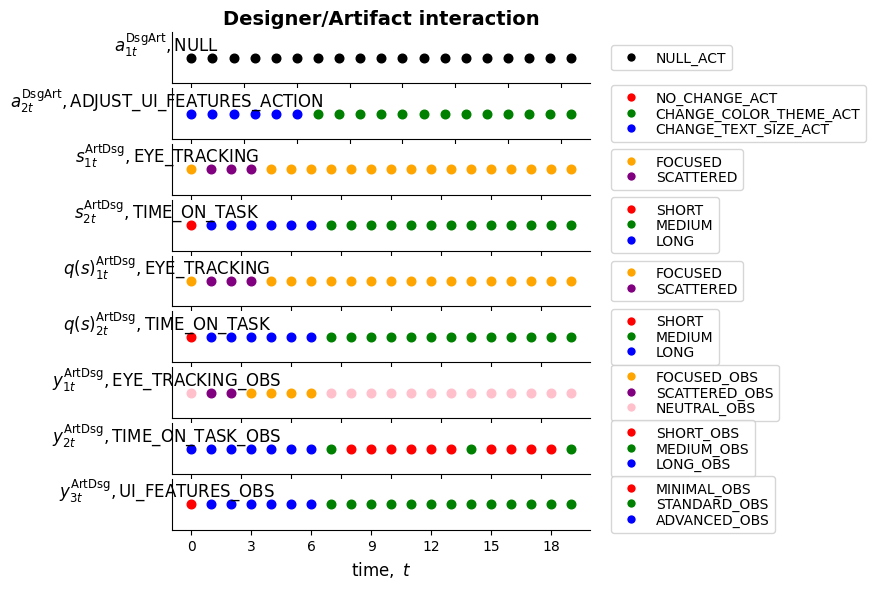

Plot saved as 'Designer-Artifact.png'.


<Figure size 640x480 with 0 Axes>

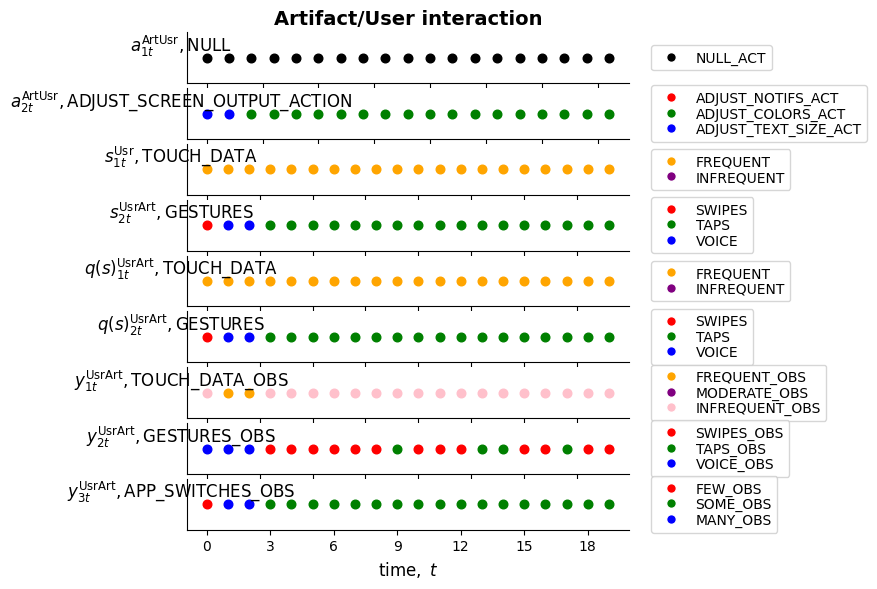

Plot saved as 'Artifact-User.png'.


<Figure size 640x480 with 0 Axes>

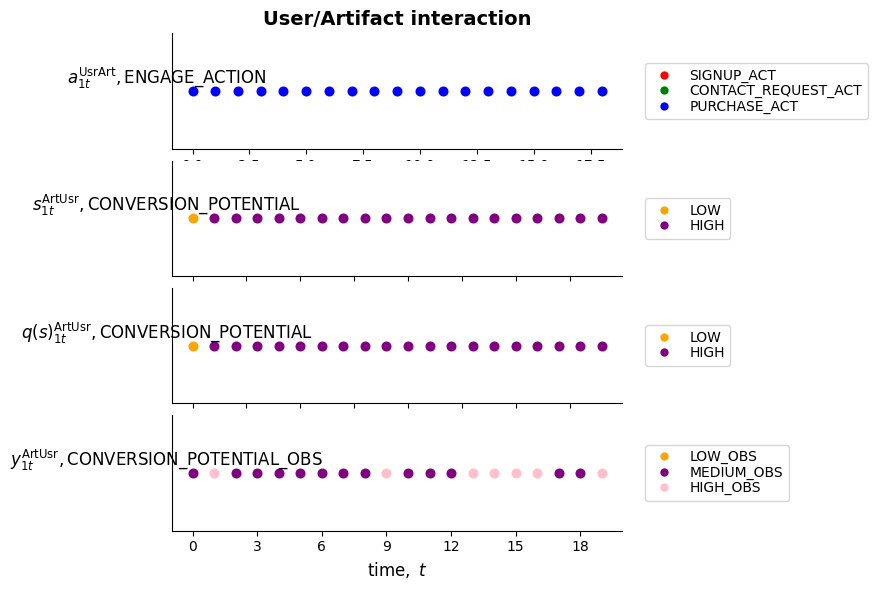

Plot saved as 'User-Artifact.png'.


<Figure size 640x480 with 0 Axes>

In [72]:
simulate(_T)

In [ ]:
## def main():
#     parser = argparse.ArgumentParser(
#         description="""
# A Designer-Artifact-User interaction simulation script.
# To execute:
# python -m dau-active-inference --duration 20
# """)
#     parser.add_argument(
#         "--duration", 
#         type=str, 
#         default=20,
#         help="The time duration of the simulation, i.e. the number of time steps.", 
#         required=True)
#     args = parser.parse_args(); print(f"Duration, {args.duration}")

#     simulate(int(args.duration))

# if __name__ == "__main__":
#     main()